In [17]:
#ローカルレベルモデルのスクラッチ実装
#基本的なデータセットのみ取得
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pylab as plt
import seaborn as sns
import numpy.random as rd
sns.set()

In [18]:
#予測するデータを作る
np.random.seed(1)
sim_size = 100

#make random walk process
mu = np.cumsum(stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)) + 30

#make obs
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

#make time index
y_ts = pd.Series(y, index=pd.date_range(start='2020-01-01', periods=sim_size, freq='D'))

<Axes: >

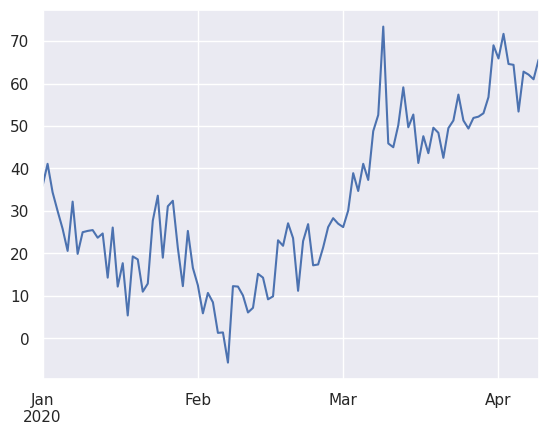

In [19]:
y_ts.plot()

In [20]:
#local level class

class LocalLevel:
  #storage dataset and make sum zeros dataset, a is state, P is V of State, v is gap of obs and estimated obs,
  #F is P + V of obs, K is is Kalman Gain, s_level is V of state, s_irregular is V of obs

  #make initializer
  def __init__(self, ts_data):
    self.ts_data = ts_data
    self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.s_level = None
    self.s_irregular = None

  #set initial function, you can set initial a and P.
  def initialize(self, initial_a, initial_P):
    self.initial_a = initial_a
    self.initial_P = initial_P

  #Predict one point ahead function
  def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
    #first step, you use initial a and P
    if first:
      a_forecast = self.initial_a
      P_forecast = self.initial_P
    else:
      a_forecast = a_pre
      P_forecast = P_pre + s_level

    y_forecast = a_forecast
    F = P_forecast + s_irregular

    return(pd.Series([a_forecast, P_forecast, y_forecast, F], index=['a', 'P', 'y', 'F']))

  #Filter mothod
  def _filter_step(self, forecasted, y, s_irregular):
    v = y - forecasted.y
    K = forecasted.P / forecasted.F
    a_filter = forecasted.a + K * v
    P_filter = (1 - K) * forecasted.P

    return(pd.Series([a_filter, P_filter, v, K], index=['a', 'P', 'v', 'K']))

  def filter(self, s_irregular, s_level):
    for i in range(0, len(self.ts_data)):
      if(i == 0):
        #初回は任意の初期値を利用.forecast_step関数に引数を渡し、forecast_loopにforecast_stepの出力を保存
        forecast_loop = self._forecast_step(
            a_pre=None, P_pre=None, s_irregular=s_irregular, s_level=s_level, first=True
        )
      else:
        #1時点前の値を参照して予測する。forecast_step関数に引数を渡し、forecast_loopにforecast_stepの出力を保存
        forecast_loop = self._forecast_step(
            a_pre=self.a.iloc[i - 1], P_pre=self.P.iloc[i - 1],
            s_irregular=s_irregular, s_level=s_level
        )
      #フィルタリング実行。filter_stepの引数を渡す。フィルタリングされた値がfilter_loopに戻される。
      filter_loop = self._filter_step(
          forecasted=forecast_loop, y=self.ts_data.iloc[i], s_irregular=s_irregular
      )

      #結果の保存
      self.a.iloc[i] = filter_loop.a
      self.P.iloc[i] = filter_loop.P
      self.F.iloc[i] = forecast_loop.F
      self.K.iloc[i] = filter_loop.K
      self.v.iloc[i] = filter_loop.v

  #対数尤度関数
  def llf(self):
    return np.sum(np.log(stats.norm.pdf(
        x=self.v, loc=0, scale=np.sqrt(self.F)
        )))

  #最尤法によるパラメータ推定.フィルター関数にs_irregularとs_levelをセットしてみて、対数尤度を算出
  def fit(self, start_params):
    def calc_llf(params):
      self.filter(np.exp(params[0], np.exp(params[1])))
      return self.llf() * -1

    opt_res = minimize(calc_llf, start_params,
                       method='Nelder-Mead', tol=1e-6, options={'maxiter':2000})

    #params storage

    self.s_irregular = np.exp(opt_res.x[0])
    self.s_level = np.exp(opt_res[1])

    self.filter(self.s_irregular, self.s_level)

  #可視化
  def plot_level(self):
    plot_df = pd.concat([self.a, self.ts_data], axis=1)
    plot_df.columns = column=['filtered', 'y']
    plot_df.plot()

In [21]:
local_level = LocalLevel(y_ts)

local_level.initialize(initial_a=0, initial_P=1000000)

local_level.filter(s_irregular=10, s_level=1)

In [22]:
local_level.a.round(5).head(3)

,0
2020-01-01,35.89964
2020-01-02,38.62363
2020-01-03,37.00106


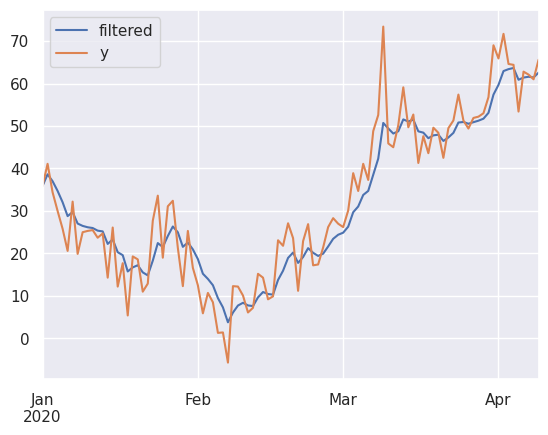

In [23]:
local_level.plot_level()

In [24]:
#stats modelを用いた状態空間モデル
mod_local_level = tsa.UnobservedComponents(y_ts, level='local level', loglikelihood_burn=0)

mod_local_level.initialize_approximate_diffuse(1000000)

res_local_level = mod_local_level.fit(
    start_params=[1,1], method='nm', maxiter=2000)

print(res_local_level.summary())

Optimization terminated successfully.
         Current function value: 3.443601
         Iterations: 53
         Function evaluations: 96
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -344.360
Date:                Wed, 12 Mar 2025   AIC                            692.720
Time:                        12:23:28   BIC                            697.931
Sample:                    01-01-2020   HQIC                           694.829
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    24.2871      5.199      4.671      0.000

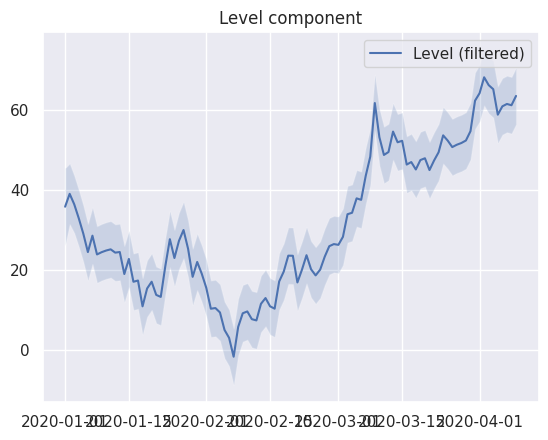

In [25]:
#フィルター化推定量と95%信頼区間
_ = res_local_level.plot_components(which='filtered', observed=False)

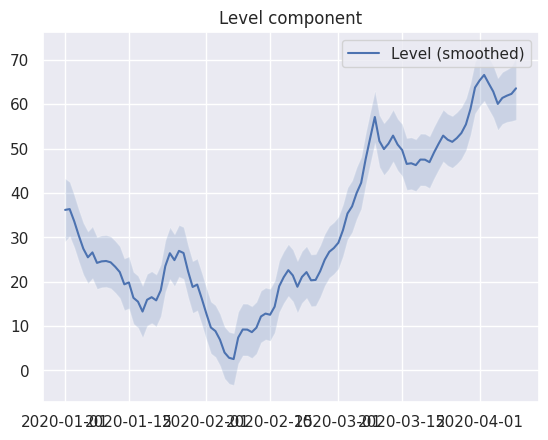

In [26]:
#平滑化済み推定量
_ = res_local_level.plot_components(which='smoothed', observed=False)

In [27]:
#パーティクルフィルター
class ParticleFilter(object):
    def __init__(self, y, n_particle, sigma_2, alpha_2):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf

    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1

    def resampling2(self, weights):
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k

    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)

        # 潜在変数
        x = np.zeros((T+1, self.n_particle))
        x_resampled = np.zeros((T+1, self.n_particle))

        # 潜在変数の初期値
        initial_x = rd.normal(0, 1, size=self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2) # y[t]に対する各粒子の尤度
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]

        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)

        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l

    def get_filtered_value(self):
        return np.diag(np.dot(self.w_normed, self.x[1:].T))


    def draw_graph(self):
        # グラフ描画
        T = len(self.y)

        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y)
        plt.plot(self.get_filtered_value(), "g")

        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color="r", s=2, alpha=0.1)

        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2,
                                                                                 self.alpha_2,
                                                                                 self.log_likelihood))

In [41]:
a = -2
b = -1

n_particle = 10**3 * 5
sigma_2 = 5
alpha_2 = 10

In [42]:
pf = ParticleFilter(y_ts.values, n_particle, sigma_2, alpha_2)

In [43]:
pf.simulate()

 calculating... t=99

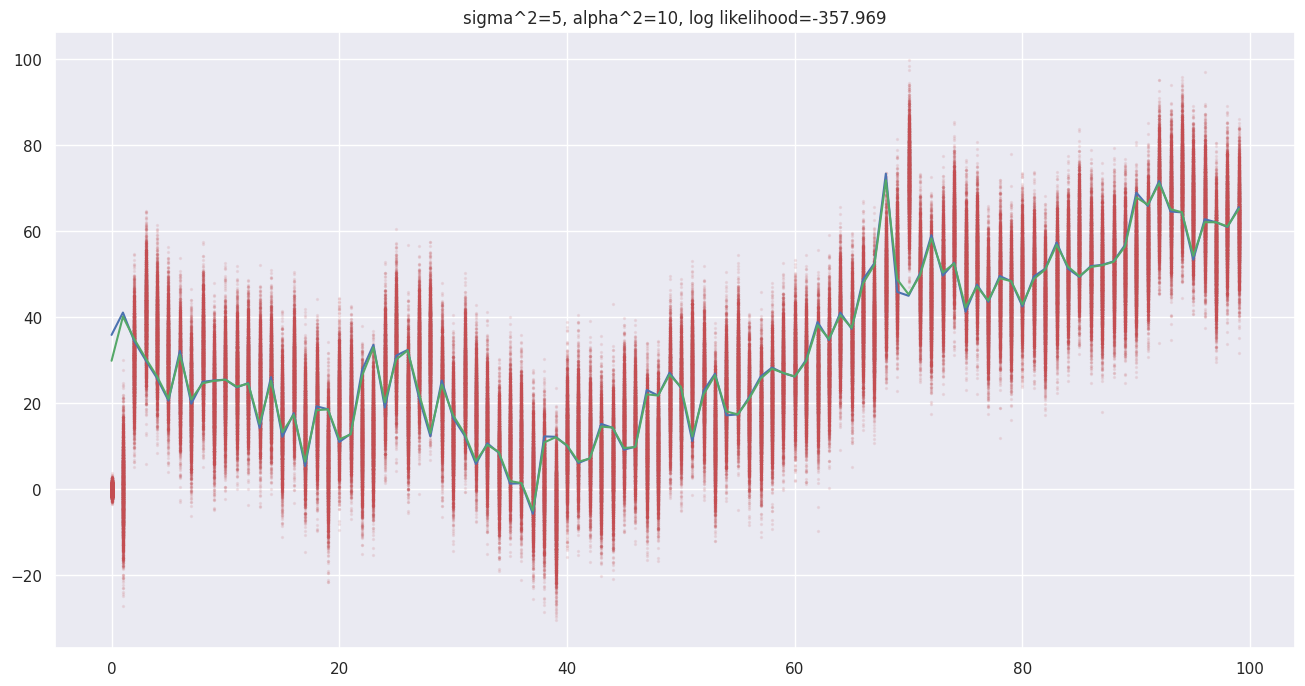

In [44]:
pf.draw_graph()